In [ ]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
from src.training.train import train_model

In [2]:
x_train = np.load('../data/stretched_x_train.npy')
y_train = np.load('../data/train_labels.npy')

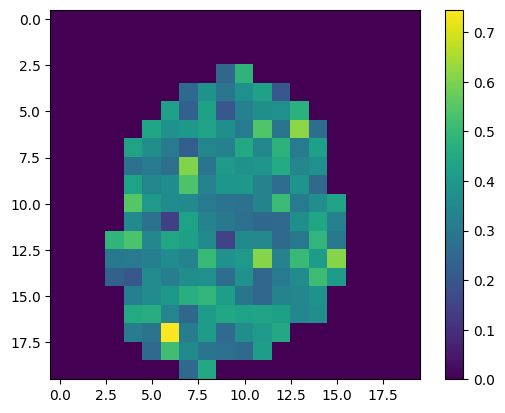

In [3]:
plt.imshow(x_train[0])
plt.colorbar()

In [4]:
config = {
    'batch_size': 30,
    'epochs': 10,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 20,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
}#np.random.rand(100, 20, 20)  # Example: 1000 images of 64x64x3

# Run the training loop
results = train_model(config, x_train)

hello
Training with batch size: 30, epochs: 10, learning rate: 0.001, seed: 42, latent dim: 20


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


Epoch 1/10: Reconstruction loss: 0.0868, Adversarial loss: 0.0407
Epoch 2/10: Reconstruction loss: 0.0422, Adversarial loss: 0.0397
Epoch 3/10: Reconstruction loss: 0.0372, Adversarial loss: 0.0391
Epoch 4/10: Reconstruction loss: 0.0330, Adversarial loss: 0.0388
Epoch 5/10: Reconstruction loss: 0.0319, Adversarial loss: 0.0404
Epoch 6/10: Reconstruction loss: 0.0312, Adversarial loss: 0.0396
Epoch 7/10: Reconstruction loss: 0.0307, Adversarial loss: 0.0400
Epoch 8/10: Reconstruction loss: 0.0307, Adversarial loss: 0.0395
Epoch 9/10: Reconstruction loss: 0.0304, Adversarial loss: 0.0396
Epoch 10/10: Reconstruction loss: 0.0300, Adversarial loss: 0.0398
Saving loss plot...
Saving model weights...
Encoder weights saved to ./results/models/encoder.weights.h5
Decoder weights saved to ./results/models/decoder.weights.h5
Discriminator weights saved to ./results/models/discriminator.weights.h5


In [6]:
from src.models import Encoder, Decoder, Discriminator

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/notebooks/results/models/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/notebooks/results/models/decoder.weights.h5")
discriminator.load_weights("/Users/inescunha/Documents/GitHub/CellFate/notebooks/results/models/discriminator.weights.h5")

In [ ]:
z_imgs, z_scores = encoder.predict(x_train)
recon = decoder.predict(z_imgs)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


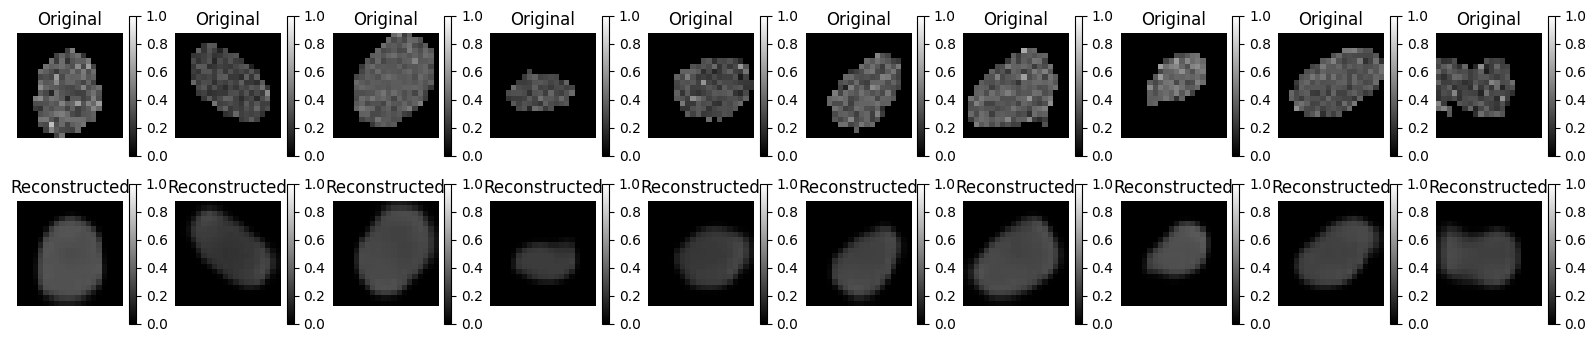

In [12]:
n = 10  # Number of images to display
latent_space, score = encoder.predict(x_train[:])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i][:, :], cmap="gray", vmin=0.0, vmax=x_train.max())  # Display channel 1 image_batch[i].reshape(20, 20, 2)
    plt.title("Original")
    plt.axis("off")
    plt.colorbar()

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(recon[i][:, :, 0], cmap="gray", vmin=0.0, vmax=x_train.max())  # Display channel 1
    plt.title("Reconstructed")
    plt.axis("off")
    plt.colorbar()
plt.show()